In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/acne04/sim_acne.csv
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_564.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_365.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_97.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_240.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_607.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_531.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_141.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_595.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_550.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_138.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_95.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_332.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_423.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_126.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_415.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_523.jpg
/kaggle/input/acne04/acne_1024/acne1_1024/levle1_553.jpg

# Data-Augumentation

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# import tensorflow_hub as hub
from tensorflow.keras import layers

2024-07-20 15:42:50.202080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 15:42:50.202188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 15:42:50.335757: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!pip install split-folders
import splitfolders

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
# Path to minority class directories
minority_class1_path = '/kaggle/input/acne04/acne_1024'
minority_class2_path = '/kaggle/input/acne04/acne_1024'

In [5]:
import os
print(os.listdir(minority_class1_path))
print(os.listdir(minority_class2_path))

['acne1_1024', 'acne3_1024', 'small_1024', 'acne0_1024', 'small_1024_renamed', 'all_1024', 'acne3_512_selection', 'acne2_1024']
['acne1_1024', 'acne3_1024', 'small_1024', 'acne0_1024', 'small_1024_renamed', 'all_1024', 'acne3_512_selection', 'acne2_1024']


In [6]:
import tensorflow as tf

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize
    return image, label


In [7]:
def get_image_paths_and_labels(class_dir, class_label):
    image_paths = tf.data.Dataset.list_files(class_dir + '/*.jpg')
    labels = tf.data.Dataset.from_tensor_slices([class_label] * len(image_paths))
    return image_paths, labels

# Prepare image paths and labels for each class
acne2_paths, acne2_labels = get_image_paths_and_labels('/kaggle/input/acne04/acne_1024/acne2_1024', 2)
acne3_paths, acne3_labels = get_image_paths_and_labels('/kaggle/input/acne04/acne_1024/acne3_1024', 3)
acne1_paths, acne1_labels = get_image_paths_and_labels('/kaggle/input/acne04/acne_1024/acne1_1024', 1)
acne0_paths, acne0_labels = get_image_paths_and_labels('/kaggle/input/acne04/acne_1024/acne0_1024', 0)

# Concatenate datasets
all_image_paths = acne2_paths.concatenate(acne3_paths).concatenate(acne1_paths).concatenate(acne0_paths)
all_labels = acne2_labels.concatenate(acne3_labels).concatenate(acne1_labels).concatenate(acne0_labels)


In [8]:
# Combine image paths and labels into a dataset
dataset = tf.data.Dataset.zip((all_image_paths, all_labels))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [9]:
import tensorflow as tf

# Define dataset split fraction
split_fraction = 0.8  # 80% training, 20% validation

# Shuffle and split the dataset
dataset = dataset.shuffle(buffer_size=1000, seed=42)
total_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(total_size * split_fraction)
val_size = total_size - train_size

# Create training and validation datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Batch and prefetch the datasets
batch_size = 32

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [10]:
dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [11]:
for images, labels in train_dataset.take(1):
    print(images.shape)  # Should be (batch_size, 224, 224, 3)
    print(labels.shape)  # Should be (batch_size,)

(32, 224, 224, 3)
(32,)


In [12]:
for images, labels in val_dataset.take(1):
    print(images.shape)  # Should be (batch_size, 224, 224, 3)
    print(labels.shape)  # Should be (batch_size,)

(32, 224, 224, 3)
(32,)


### Simple CNN

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [28]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=18  # Adjust the number of epochs as needed
)

Epoch 1/18
 3/35 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2431 - loss: 10.9315

W0000 00:00:1721490891.770017     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3733 - loss: 7.7572

W0000 00:00:1721490896.769715     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.3739 - loss: 7.6572 - val_accuracy: 0.4167 - val_loss: 1.2135
Epoch 2/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.5158 - loss: 1.1729 - val_accuracy: 0.6268 - val_loss: 0.9454
Epoch 3/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.6081 - loss: 0.9444 - val_accuracy: 0.7717 - val_loss: 0.7312
Epoch 4/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.7365 - loss: 0.7241 - val_accuracy: 0.8587 - val_loss: 0.5240
Epoch 5/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.8586 - loss: 0.4692 - val_accuracy: 0.9167 - val_loss: 0.3076
Epoch 6/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.8956 - loss: 0.3647 - val_accuracy: 0.9674 - val_loss: 0.1870
Epoch 7/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9525 - loss: 0.2178 - val_accuracy: 0.9891 - val_loss: 0.1048
Epoch 8/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.9698 - loss: 0.1415 - val_accuracy: 0.9928 - val_

In [32]:
# Training metrics
print("Training Metrics:")
for epoch in range(10):
    print(f"Epoch {epoch + 1}:")
    print(f" - Loss: {history.history['loss'][epoch]}")
    print(f" - Accuracy: {history.history['accuracy'][epoch]}")
    if 'val_loss' in history.history:
        print(f" - Validation Loss: {history.history['val_loss'][epoch]}")
        print(f" - Validation Accuracy: {history.history['val_accuracy'][epoch]}")


Training Metrics:
Epoch 1:
 - Loss: 4.155745983123779
 - Accuracy: 0.3914622962474823
 - Validation Loss: 1.2135334014892578
 - Validation Accuracy: 0.4166666567325592
Epoch 2:
 - Loss: 1.1561131477355957
 - Accuracy: 0.47411444783210754
 - Validation Loss: 0.9454389810562134
 - Validation Accuracy: 0.6268116235733032
Epoch 3:
 - Loss: 0.9172097444534302
 - Accuracy: 0.6230699419975281
 - Validation Loss: 0.7312474250793457
 - Validation Accuracy: 0.77173912525177
Epoch 4:
 - Loss: 0.6739767789840698
 - Accuracy: 0.7565849423408508
 - Validation Loss: 0.5240192413330078
 - Validation Accuracy: 0.8586956262588501
Epoch 5:
 - Loss: 0.4567404091358185
 - Accuracy: 0.8664849996566772
 - Validation Loss: 0.30759504437446594
 - Validation Accuracy: 0.9166666865348816
Epoch 6:
 - Loss: 0.3316996395587921
 - Accuracy: 0.9155313372612
 - Validation Loss: 0.186987966299057
 - Validation Accuracy: 0.967391312122345
Epoch 7:
 - Loss: 0.20892153680324554
 - Accuracy: 0.9582198262214661
 - Validatio

In [33]:
import matplotlib.pyplot as plt
def printMetric(model):
    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9958 - loss: 0.0302
Validation Loss: 0.038519635796546936
Validation Accuracy: 0.989130437374115


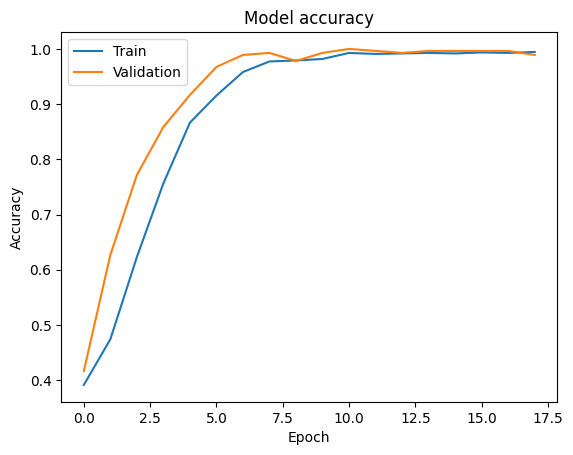

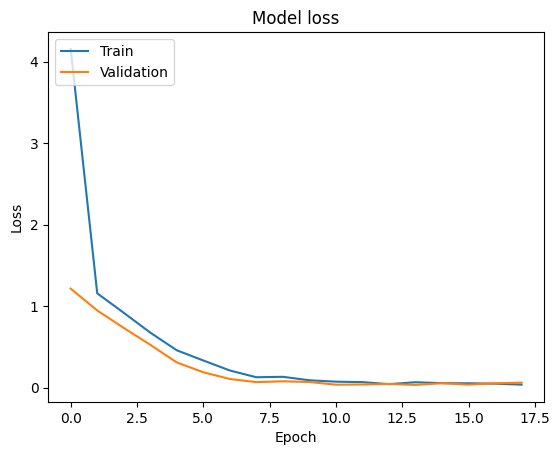

In [34]:
printMetric(model)

### ResNet50

In [35]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Number of classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [37]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs as needed
)


Epoch 1/10
 1/35 ━━━━━━━━━━━━━━━━━━━━ 6:35 12s/step - accuracy: 0.1250 - loss: 1.4948

W0000 00:00:1721491085.243419     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3572 - loss: 1.5320

W0000 00:00:1721491090.394015     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721491096.487042     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step - accuracy: 0.3578 - loss: 1.5290 - val_accuracy: 0.3442 - val_loss: 1.2465
Epoch 2/10


W0000 00:00:1721491098.804954     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.4496 - loss: 1.2902 - val_accuracy: 0.3949 - val_loss: 1.1273
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - accuracy: 0.4278 - loss: 1.2332 - val_accuracy: 0.4022 - val_loss: 1.2798
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.3861 - loss: 1.3401 - val_accuracy: 0.4094 - val_loss: 1.2197
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.5162 - loss: 1.1741 - val_accuracy: 0.3986 - val_loss: 1.2461
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.4063 - loss: 1.2886 - val_accuracy: 0.3841 - val_loss: 1.2039
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.5032 - loss: 1.2173 - val_accuracy: 0.4348 - val_loss: 1.1824
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.4901 - loss: 1.1858 - val_accuracy: 0.4420 - val_loss: 1.1357
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.4785 - loss: 1.2287 - val_accuracy: 0.4203 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.4296 - loss: 1.1072
Validation Loss: 1.0961263179779053
Validation Accuracy: 0.4492753744125366


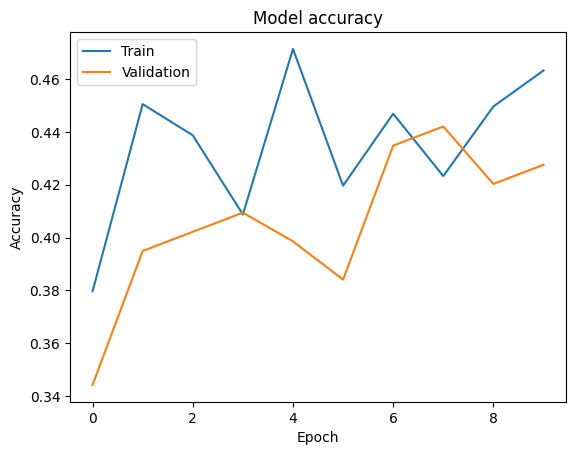

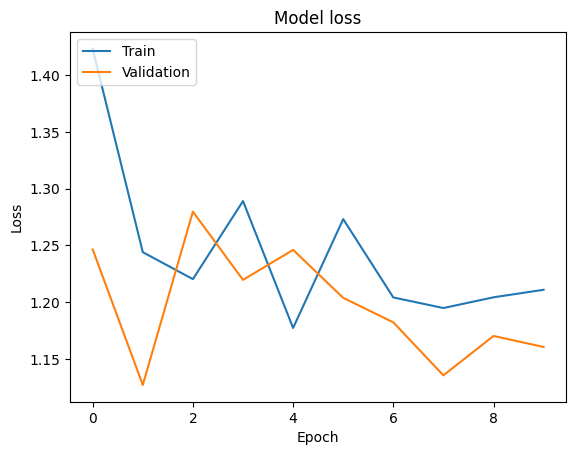

In [38]:
printMetric(model)

#### unfreezing layers for fine tuning

In [39]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust as needed
)


Epoch 1/10
 1/35 ━━━━━━━━━━━━━━━━━━━━ 10:23 18s/step - accuracy: 0.0625 - loss: 3.5719

W0000 00:00:1721491193.456678     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.4193 - loss: 1.4753

W0000 00:00:1721491203.183494     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721491209.649356     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 37s 542ms/step - accuracy: 0.4193 - loss: 1.4694 - val_accuracy: 0.4348 - val_loss: 6.1077
Epoch 2/10


W0000 00:00:1721491211.964130     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.4130 - loss: 1.2438 - val_accuracy: 0.4674 - val_loss: 28.4762
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.4316 - loss: 1.1544 - val_accuracy: 0.3551 - val_loss: 38.2102
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.3673 - loss: 1.2050 - val_accuracy: 0.4275 - val_loss: 38.5145
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.3838 - loss: 1.1341 - val_accuracy: 0.4167 - val_loss: 16.2151
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - accuracy: 0.4105 - loss: 1.1040 - val_accuracy: 0.4275 - val_loss: 7.3807
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.5362 - loss: 1.0680 - val_accuracy: 0.4167 - val_loss: 2.7373
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.5662 - loss: 1.0125 - val_accuracy: 0.3768 - val_loss: 3.4612
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.4176 - loss: 1.0731 - val_accuracy: 0.0725 - 

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3944 - loss: 14.6847
Validation Loss: 12.860068321228027
Validation Accuracy: 0.4021739065647125


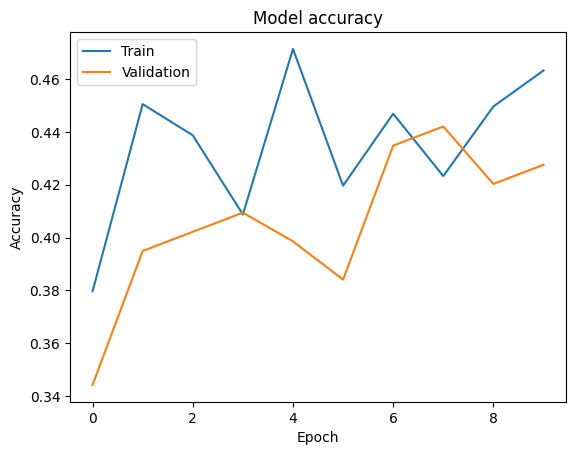

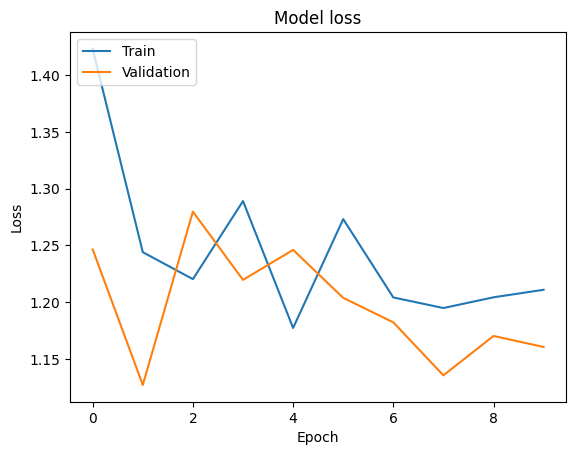

In [40]:
printMetric(model)


### VGG16

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load VGG16 without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Number of classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs as needed
)


Epoch 1/10
 1/35 ━━━━━━━━━━━━━━━━━━━━ 19:51 35s/step - accuracy: 0.0000e+00 - loss: 1.4477

W0000 00:00:1721491330.018675     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.3994 - loss: 1.2849

W0000 00:00:1721491352.997398     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4004 - loss: 1.2829 - val_accuracy: 0.4457 - val_loss: 1.2200
Epoch 2/10


W0000 00:00:1721491374.410005     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.4919 - loss: 1.1425 - val_accuracy: 0.5000 - val_loss: 1.0315
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.4472 - loss: 1.2162 - val_accuracy: 0.4891 - val_loss: 1.0938
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - accuracy: 0.5381 - loss: 1.0794 - val_accuracy: 0.4674 - val_loss: 1.0297
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5354 - loss: 1.0507 - val_accuracy: 0.5507 - val_loss: 0.9337
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.5517 - loss: 1.0389 - val_accuracy: 0.5145 - val_loss: 0.9539
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5787 - loss: 0.9686 - val_accuracy: 0.5326 - val_loss: 0.9323
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5626 - loss: 0.9496 - val_accuracy: 0.5399 - val_loss: 0.9543
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.5929 - loss: 0.9351 - val_accuracy: 0.583

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5845 - loss: 0.9261
Validation Loss: 0.9015872478485107
Validation Accuracy: 0.6050724387168884


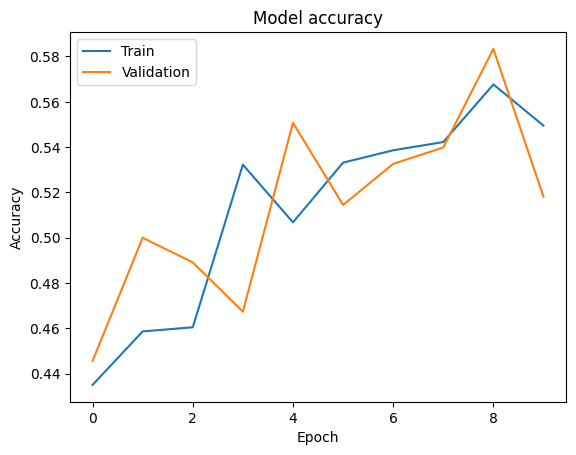

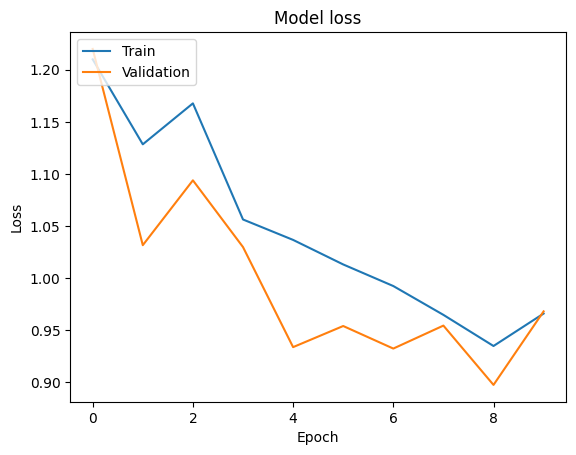

In [43]:
printMetric(model)


In [44]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust as needed
)


Epoch 1/10


W0000 00:00:1721491520.588896     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.3715 - loss: 107.3545

W0000 00:00:1721491557.757892     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3721 - loss: 105.2852   

W0000 00:00:1721491561.193182     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.3726 - loss: 103.3308 - val_accuracy: 0.4855 - val_loss: 1.1305
Epoch 2/10


W0000 00:00:1721491562.559124     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - accuracy: 0.4905 - loss: 1.2080 - val_accuracy: 0.4203 - val_loss: 1.1162
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 483ms/step - accuracy: 0.5091 - loss: 1.1910 - val_accuracy: 0.3986 - val_loss: 1.1929
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 494ms/step - accuracy: 0.4488 - loss: 1.2144 - val_accuracy: 0.3514 - val_loss: 1.2019
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - accuracy: 0.3514 - loss: 1.2445 - val_accuracy: 0.4529 - val_loss: 1.2035
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 476ms/step - accuracy: 0.4870 - loss: 1.2241 - val_accuracy: 0.3949 - val_loss: 1.1537
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 479ms/step - accuracy: 0.3908 - loss: 1.2208 - val_accuracy: 0.3986 - val_loss: 1.1829
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 479ms/step - accuracy: 0.4649 - loss: 1.1791 - val_accuracy: 0.4239 - val_loss: 1.1778
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - accuracy: 0.4794 - loss: 1.2545 - val_accuracy: 0.362

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.4087 - loss: 1.2221
Validation Loss: 1.2178107500076294
Validation Accuracy: 0.4021739065647125


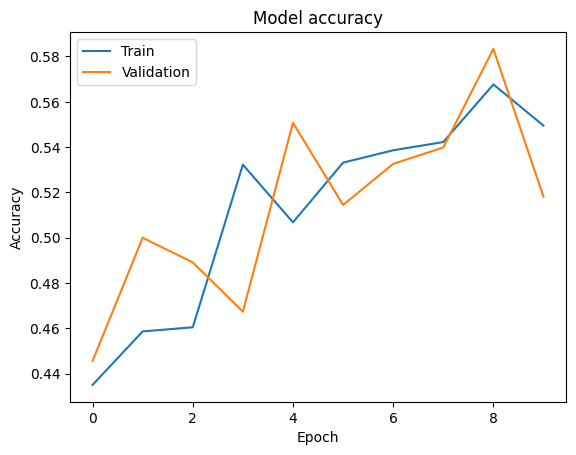

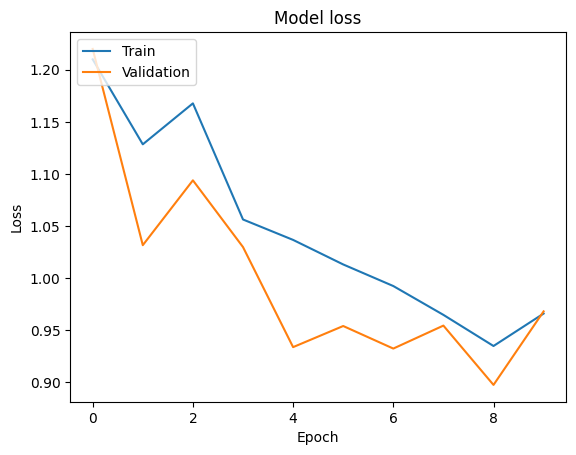

In [45]:
printMetric(model)


### EfficientNetB0

In [46]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load EfficientNetB0 without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Number of classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [61]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 8,617,678 (32.87 MB)

 Trainable params: 2,521,924 (9.62 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 5,043,850 (19.24 MB)

In [47]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust the number of epochs as needed
)


Epoch 1/10
 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.2587 - loss: 1.3329 

W0000 00:00:1721491772.039132     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.4519 - loss: 1.2101

W0000 00:00:1721491802.882504     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4513 - loss: 1.2099 - val_accuracy: 0.4239 - val_loss: 1.1761
Epoch 2/10


W0000 00:00:1721491811.329405     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.4784 - loss: 1.2383 - val_accuracy: 0.3659 - val_loss: 1.1866
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4203 - loss: 1.2264 - val_accuracy: 0.4094 - val_loss: 1.1775
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.5043 - loss: 1.2135 - val_accuracy: 0.3696 - val_loss: 1.2123
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.4843 - loss: 1.2338 - val_accuracy: 0.3913 - val_loss: 1.2094
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.5099 - loss: 1.1831 - val_accuracy: 0.4203 - val_loss: 1.1393
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.4881 - loss: 1.2368 - val_accuracy: 0.4493 - val_loss: 1.1811
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.4891 - loss: 1.1849 - val_accuracy: 0.4312 - val_loss: 1.1680
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.5140 - loss: 1.1919 - val_accuracy: 0.4601 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4077 - loss: 1.2138
Validation Loss: 1.1697717905044556
Validation Accuracy: 0.43478259444236755


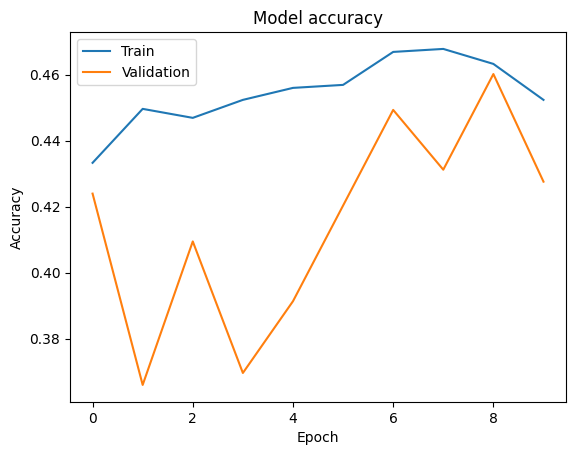

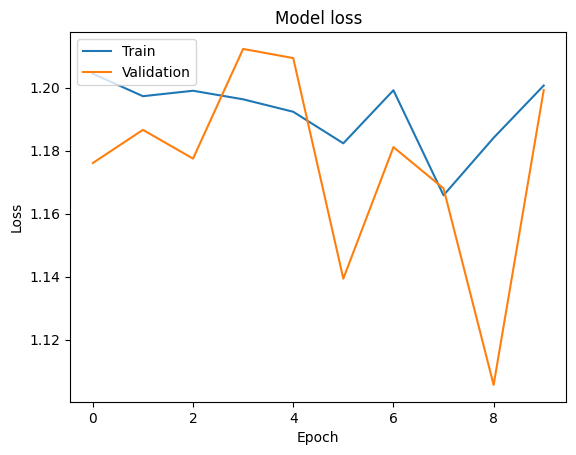

In [48]:
printMetric(model)


In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=18  # Adjust the number of epochs as needed
)

Epoch 1/18
 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.6146 - loss: 1.2294 

W0000 00:00:1721491899.439836     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.5115 - loss: 1.2011

W0000 00:00:1721491923.315590     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 54s 793ms/step - accuracy: 0.5101 - loss: 1.2002 - val_accuracy: 0.4710 - val_loss: 1.1298
Epoch 2/18


W0000 00:00:1721491926.386821     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.5206 - loss: 1.1960 - val_accuracy: 0.4312 - val_loss: 1.1315
Epoch 3/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.5104 - loss: 1.1756 - val_accuracy: 0.4384 - val_loss: 1.1554
Epoch 4/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4743 - loss: 1.2205 - val_accuracy: 0.4094 - val_loss: 1.2024
Epoch 5/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4962 - loss: 1.2110 - val_accuracy: 0.3442 - val_loss: 1.1883
Epoch 6/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.4998 - loss: 1.1861 - val_accuracy: 0.4058 - val_loss: 1.2005
Epoch 7/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.5050 - loss: 1.2146 - val_accuracy: 0.4348 - val_loss: 1.1735
Epoch 8/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.5212 - loss: 1.1757 - val_accuracy: 0.4493 - val_loss: 1.1595
Epoch 9/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.5072 - loss: 1.1663 - val_accuracy: 0.4275 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4559 - loss: 1.1326
Validation Loss: 1.1539371013641357
Validation Accuracy: 0.4492753744125366


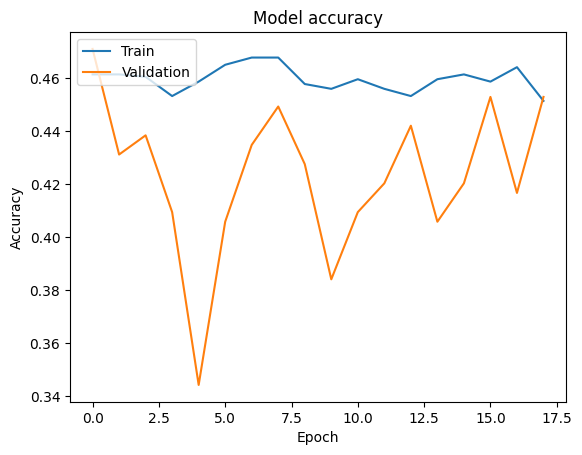

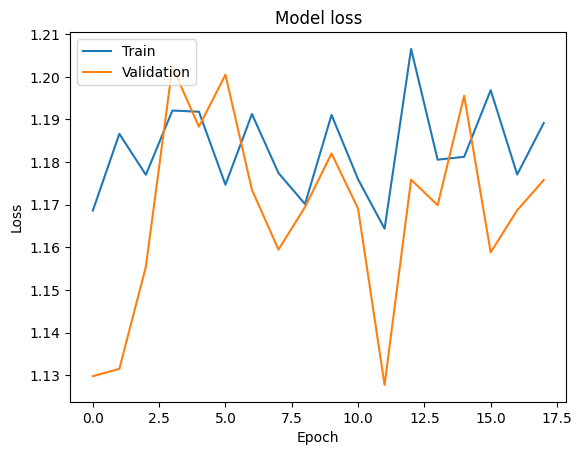

In [50]:
printMetric(model)


### InceptionV3

In [73]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load InceptionV3 without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Number of classes

# Define the model
modelf = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


In [74]:
modelf.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_99[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_7[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_100[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_101[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [75]:
modelf.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = modelf.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=18  # Adjust the number of epochs as needed
)


Epoch 1/18
 2/35 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.2188 - loss: 3.4346

W0000 00:00:1721493134.528507     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3887 - loss: 2.8105

W0000 00:00:1721493140.573078     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721493148.164383     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 500ms/step - accuracy: 0.3900 - loss: 2.7838 - val_accuracy: 0.4964 - val_loss: 0.9780
Epoch 2/18


W0000 00:00:1721493151.537568     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.5671 - loss: 0.9255 - val_accuracy: 0.5326 - val_loss: 0.8799
Epoch 3/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.6304 - loss: 0.8163 - val_accuracy: 0.5399 - val_loss: 0.8544
Epoch 4/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.5380 - loss: 0.9041 - val_accuracy: 0.6051 - val_loss: 0.7726
Epoch 5/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.6343 - loss: 0.7655 - val_accuracy: 0.7138 - val_loss: 0.7020
Epoch 6/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.6551 - loss: 0.7535 - val_accuracy: 0.6304 - val_loss: 0.7445
Epoch 7/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.6537 - loss: 0.7448 - val_accuracy: 0.6920 - val_loss: 0.6525
Epoch 8/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.6401 - loss: 0.7167 - val_accuracy: 0.7246 - val_loss: 0.6540
Epoch 9/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.6962 - loss: 0.6499 - val_accuracy: 0.7536 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8661 - loss: 0.3861
Validation Loss: 0.3818552792072296
Validation Accuracy: 0.8586956262588501


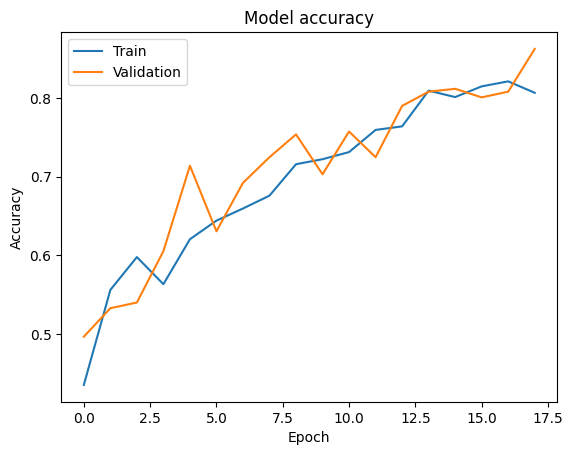

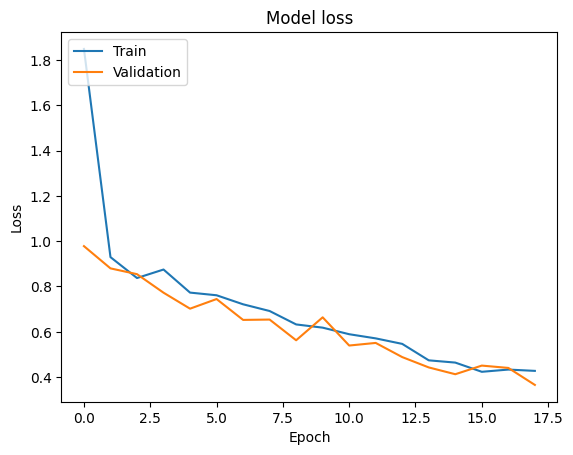

In [76]:
printMetric(modelf)


In [78]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model
modelf.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine_tune = modelf.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=18  # Adjust as needed
)


Epoch 1/18
 2/35 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.4297 - loss: 1.2459

W0000 00:00:1721493624.644203     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6003 - loss: 1.0941

W0000 00:00:1721493631.989901     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721493639.628277     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.6001 - loss: 1.0917 - val_accuracy: 0.4384 - val_loss: 2.4803
Epoch 2/18


W0000 00:00:1721493642.974533     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.6670 - loss: 0.6988 - val_accuracy: 0.7319 - val_loss: 0.5982
Epoch 3/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.7003 - loss: 0.6253 - val_accuracy: 0.6848 - val_loss: 0.6146
Epoch 4/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8584 - loss: 0.4015 - val_accuracy: 0.8804 - val_loss: 0.2836
Epoch 5/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.8577 - loss: 0.3370 - val_accuracy: 0.9275 - val_loss: 0.2121
Epoch 6/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8631 - loss: 0.3168 - val_accuracy: 0.9493 - val_loss: 0.1567
Epoch 7/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8910 - loss: 0.2677 - val_accuracy: 0.7971 - val_loss: 0.4125
Epoch 8/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.8994 - loss: 0.2528 - val_accuracy: 0.9674 - val_loss: 0.1178
Epoch 9/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.9467 - loss: 0.1536 - val_accuracy: 0.9710 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.9811 - loss: 0.0722
Validation Loss: 0.07154012471437454
Validation Accuracy: 0.9818840622901917


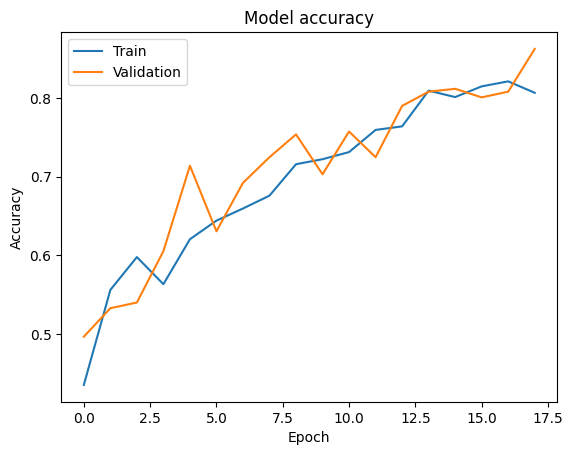

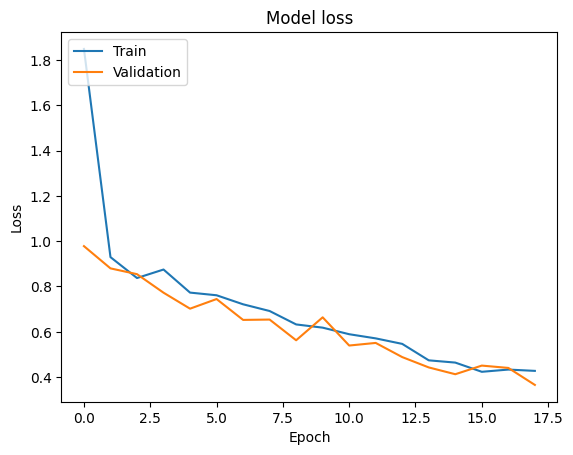

In [79]:
printMetric(modelf)


### MobileNetV2

In [64]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load MobileNetV2 without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # Number of classes

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False


In [65]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=18  # Adjust the number of epochs as needed
)


Epoch 1/18
 4/35 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3099 - loss: 2.5426

W0000 00:00:1721492652.349952     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4051 - loss: 1.8496

W0000 00:00:1721492661.498477     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.4065 - loss: 1.8367 - val_accuracy: 0.5725 - val_loss: 0.9039
Epoch 2/18


W0000 00:00:1721492663.342965     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.6469 - loss: 0.8467 - val_accuracy: 0.7174 - val_loss: 0.6611
Epoch 3/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.6994 - loss: 0.6931 - val_accuracy: 0.7645 - val_loss: 0.6291
Epoch 4/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.6927 - loss: 0.6634 - val_accuracy: 0.6993 - val_loss: 0.6367
Epoch 5/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.7232 - loss: 0.6434 - val_accuracy: 0.7754 - val_loss: 0.5422
Epoch 6/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.7491 - loss: 0.6077 - val_accuracy: 0.7246 - val_loss: 0.5984
Epoch 7/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.7455 - loss: 0.5560 - val_accuracy: 0.8297 - val_loss: 0.4615
Epoch 8/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.8323 - loss: 0.4432 - val_accuracy: 0.8297 - val_loss: 0.4102
Epoch 9/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.8275 - loss: 0.4438 - val_accuracy: 0.8406 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7869 - loss: 0.4432
Validation Loss: 0.46547383069992065
Validation Accuracy: 0.7753623127937317


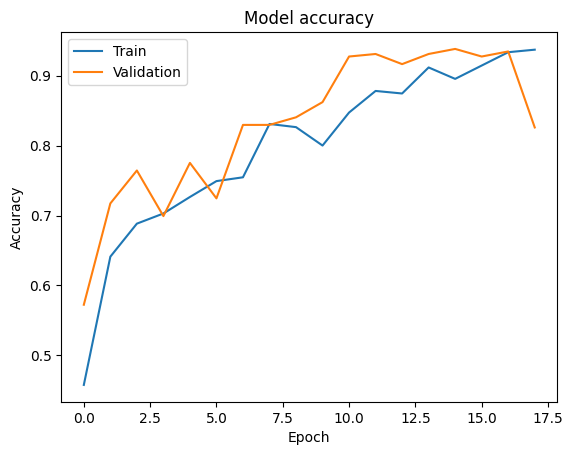

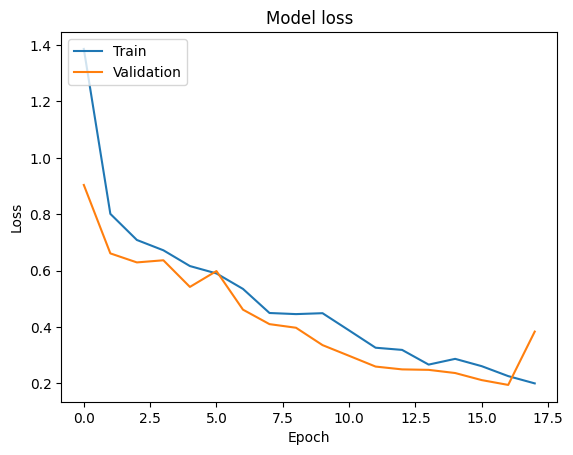

In [66]:
printMetric(model)


In [67]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Recompile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=18  # Adjust as needed
)


Epoch 1/18
 3/35 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5538 - loss: 2.1298

W0000 00:00:1721492786.966883     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5340 - loss: 1.8207

W0000 00:00:1721492792.066217     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721492797.305987     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 25s 357ms/step - accuracy: 0.5346 - loss: 1.8067 - val_accuracy: 0.4638 - val_loss: 7.4450
Epoch 2/18


W0000 00:00:1721492799.109185     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.7116 - loss: 0.6786 - val_accuracy: 0.4275 - val_loss: 7.6493
Epoch 3/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.7905 - loss: 0.5039 - val_accuracy: 0.5036 - val_loss: 4.0005
Epoch 4/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.8590 - loss: 0.3224 - val_accuracy: 0.4819 - val_loss: 4.1699
Epoch 5/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.8493 - loss: 0.3873 - val_accuracy: 0.5109 - val_loss: 4.0626
Epoch 6/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.8463 - loss: 0.4003 - val_accuracy: 0.7029 - val_loss: 2.9164
Epoch 7/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9007 - loss: 0.2481 - val_accuracy: 0.5471 - val_loss: 3.1686
Epoch 8/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9268 - loss: 0.2151 - val_accuracy: 0.6775 - val_loss: 2.0890
Epoch 9/18
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9171 - loss: 0.1718 - val_accuracy: 0.7681 - val_

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5684 - loss: 4.2364
Validation Loss: 4.333128452301025
Validation Accuracy: 0.5724637508392334


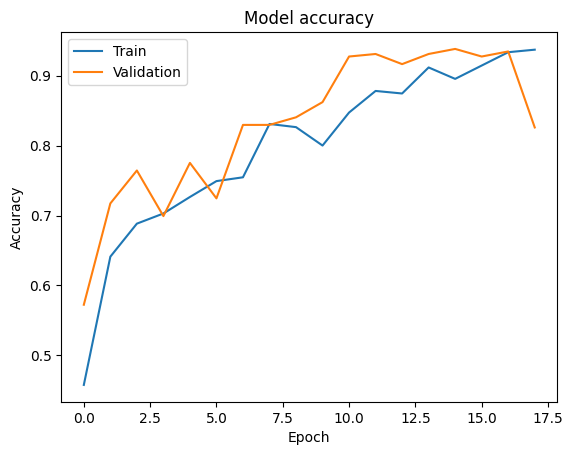

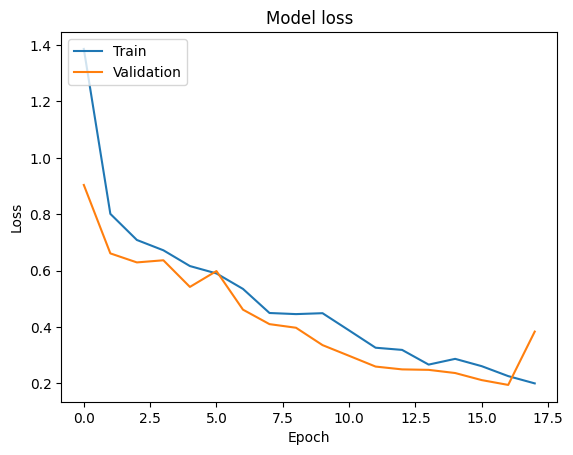

In [68]:
printMetric(model)

### Saving the model

In [82]:
# Save the model in TensorFlow SavedModel format
modelf.save('C:/Users/adrij/OneDrive/Desktop/skin-recommendation/TDL/skinAcneModel.h5')


In [83]:
loaded_model = tf.keras.models.load_model('C:/Users/adrij/OneDrive/Desktop/skin-recommendation/TDL/skinAcneModel.h5')

In [69]:
def load_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize
    return image




In [91]:
def predict_image(image_path):
    image = load_preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class[0]

In [92]:
image_path='/kaggle/input/acne04/acne_1024/acne0_1024/levle0_162.jpg'
predicted_class = predict_image(image_path)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: 0


In [95]:
image_path='/kaggle/input/acne04/acne_1024/acne2_1024/levle2_8.jpg'
predicted_class = predict_image(image_path)
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class: 2
